In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
pip install -qq https://github.com/pyannote/pyannote-audio/archive/refs/heads/develop.zip

In [ ]:
pip install seaborn

In [2]:
from pyannote.core import Annotation, Segment
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.metrics.diarization import JaccardErrorRate
from pyannote.metrics.diarization import DiarizationPurity
from pyannote.database.util import load_rttm
import pandas as pd
import os

In [3]:
import seaborn as sns
import matplotlib.pyplot

In [6]:
#Инициализация классов-метрик
jaccardErrorRate = JaccardErrorRate()
purity = DiarizationPurity()

In [76]:
#Загрузка всех аннотаций 
def annotSetJER(RefRttm, HypoRttm):
    Ref = Annotation()
    Hypo = Annotation()

    for segment, speaker, label in RefRttm.itertracks(yield_label=True):
        if label == "Interviewer":
            Ref[segment] = label
            
    for segment, speaker, label in HypoRttm.itertracks(yield_label=True):
        if label == "Interviewer":
            Hypo[segment] = label


    return Ref, Hypo

In [70]:
from pydub import AudioSegment

def annotSetF1(RefRttm, HypoRttm, wav_path):
    audio = AudioSegment.from_file(wav_path)
    eof = audio.duration_seconds
    
    Ref = Annotation()
    Hypo = Annotation()
    
    Ref[Segment(0, eof)] = "Zero"
    Ref = Ref.extrude(RefRttm.get_timeline())
    for segment, speaker, label in RefRttm.itertracks(yield_label=True):
        if label == "Interviewer":
            Ref[segment] = label

    Hypo[Segment(0, eof)] = "Zero"
    Hypo = Hypo.extrude(HypoRttm.get_timeline())
    for segment, speaker, label in HypoRttm.itertracks(yield_label=True):
        if label == "Interviewer":
            Hypo[segment] = label


    return Ref, Hypo

In [74]:
#Подсчет метрик Accuracy, Precision, Recall, F1
def stats(ref, hypo, method, table):
    gTP = 0
    gTN = 0
    gFP = 0
    gFN = 0

    speaker = "Interviewer"
    truePositive = 0
    trueNegative = 0
    falsePositive = 0
    falseNegative = 0

    truePositive = purity(ref.subset([speaker]),hypo.subset([speaker]), detailed=True)['total']
    trueNegative = purity(ref.subset([speaker],invert=True),hypo.subset([speaker],invert=True), detailed=True)['total']
    falsePositive = purity(ref.subset([speaker],invert=True),hypo.subset([speaker]), detailed=True)['total']
    falseNegative = purity(ref.subset([speaker]),hypo.subset([speaker],invert=True), detailed=True)['total']
    
    gTP += truePositive
    gTN += trueNegative
    gFP += falsePositive
    gFN += falseNegative
    #print('truePositive: ' + str(truePositive))
    #print('trueNegative: ' + str(trueNegative))
    #print('falsePositive: ' + str(falsePositive))
    #print('falseNegative: ' + str(falseNegative))
    Accuracy = (truePositive+trueNegative)/(falsePositive+falseNegative+truePositive+trueNegative)

    temp = falsePositive+truePositive
    Precision = (truePositive)/temp if temp != 0 else 0

    temp = falseNegative+truePositive
    Recall = (truePositive)/temp if temp != 0 else 0
    #print(Recall)
    F1 = (2*Recall*Precision)/(Recall+Precision) if Recall+Precision != 0 else 0

    table.loc[len(table)] = [method, speaker, round(Accuracy,2), round(Precision,2), round(Recall,2), round(F1,2)]
    
    global ggTP, ggTN, ggFP, ggFN
    
    global globalAccuracy, globalPrecision, globalRecall, globalF1
    
    ggTP += gTP
    ggTN += gTN
    ggFP += gFP
    ggFN += gFN
    
    gAccuracy = (gTP+gTN)/(gFP+gFN+gTP+gTN)
    gPrecision = gTP/(gFP+gTP) if gFP+gTP != 0 else 0
    gRecall = gTP/(gFN+gTP) if gFN+gTP != 0 else 0
    gF1 = (2*gRecall*gPrecision)/(gRecall+gPrecision) if gRecall+gPrecision != 0 else 0
    table.loc[len(table)] = [method,"Общее",round(gAccuracy,2), round(gPrecision,2) ,round(gRecall,2), round(gF1,2) ]

    globalAccuracy += gAccuracy / count
    globalPrecision += gPrecision / count
    globalRecall += gRecall / count
    globalF1 += gF1 / count

#Выполнение подсчета метрик для всех данных
def st(Ref, Hypo, methodName, table):
    stats(Ref, Hypo, methodName, table)

#################################################################################################################

def JERstats(ref, hypo, name, table):
    speakers = jaccardErrorRate(ref, hypo, detailed=True)['speaker count']
    JER = round(jaccardErrorRate(ref, hypo, detailed=True)['jaccard error rate']*100, 2)
    speakerError = round(jaccardErrorRate(ref, hypo, detailed=True)['speaker error'] * 100, 2)
    
    global gSpeakers, gSpeakerError, count
    global globalJER
    
    gSpeakers += jaccardErrorRate(ref, hypo, detailed=True)['speaker count']
    gSpeakerError += jaccardErrorRate(ref, hypo, detailed=True)['speaker error']
    #print("Conf: " + str(gConf[0]) + "\nTime: " + str(gTime[0]))
    globalJER += JER / count
    table.loc[len(table)] = [ name, speakers, speakerError ,JER ]

def stJer(Ref, Hypo, methodName, table):
    JERstats(Ref, Hypo, methodName, table)

################################################################################################################

def calculateMetrics(methodName):
    ##########################################################################################################
    main_path = "C:/Users/sasha/OneDrive/Desktop/НИР/New Research/"
    folder_path = main_path + "new_diar/"
    RefRttm_path = "Reference/"
    HypoRttm_path = methodName + "/"
    research_path = main_path + "results/"
    
    # Получаем список имен файлов в папке
    RefFile_names = os.listdir(folder_path + RefRttm_path)
    HypoFile_names = os.listdir(folder_path + HypoRttm_path)
    
    # Сортируем имена файлов в алфавитном порядке
    sorted_RefFiles = sorted(RefFile_names)
    sorted_HypoFiles = sorted(HypoFile_names)
    
    RefRttm = []
    HypoRttm = []
    global count
    count = 0
    print(sorted_RefFiles)
    for files in sorted(sorted_RefFiles):
        print(folder_path + RefRttm_path + files)
        RefRttm.append(load_rttm(folder_path + RefRttm_path + files).popitem()[1])
        count += 1
    for files in sorted(sorted_HypoFiles):
        HypoRttm.append(load_rttm(folder_path + HypoRttm_path + files).popitem()[1])
        
    Ref = []
    Hypo = []
    for j in range(15):
        RefTemp, HypoTemp = annotSetF1(RefRttm[j], HypoRttm[j], "C:/Users/sasha/OneDrive/Desktop/НИР/New Research/audio/default/"+ str(j+1) +".wav")
        Ref.append(RefTemp)
        Hypo.append(HypoTemp)

    Ref2 = []
    Hypo2 = []
    for j in range(15):
        RefTemp, HypoTemp = annotSetJER(RefRttm[j], HypoRttm[j])
        Ref2.append(RefTemp)
        Hypo2.append(HypoTemp)
    ##########################################################################################################
    
    global tableF1, tableJER, tableF1Avg, tableJERAvg
    
    global globalJER
    
    global ggTP, ggTN, ggFP, ggFN
    ggTP = 0
    ggTN = 0
    ggFP = 0
    ggFN = 0
    
    if not os.path.exists(research_path + methodName + "/"):
        os.mkdir(research_path + methodName + "/")

    print(1)
    writer = pd.ExcelWriter(research_path + methodName + '/' + methodName + '_ResultsF1.xlsx', engine='xlsxwriter')
    table = pd.DataFrame(columns = ['Метод','Говорящий', 'Accuracy', 'Precision', 'Recall', 'F1'])
    for j in range(count):
        st(Ref[j], Hypo[j], methodName, table)
    table.set_index(['Метод','Говорящий']).to_excel(writer, sheet_name="Рез")
    writer.close()
    
    print(2)
    writer = pd.ExcelWriter(research_path + methodName + '/' + methodName + '_TotalF1.xlsx', engine='xlsxwriter')
    total = pd.DataFrame(columns = ['Метод', 'Accuracy', 'Precision', 'Recall', 'F1'])
    
    Accuracy = 0
    Precision = 0
    Recall = 0
    F1 = 0
    
    Accuracy = ((ggTP+ggTN)/(ggFP+ggFN+ggTP+ggTN))
    Precision = (ggTP/(ggFP+ggTP))
    Recall = (ggTP/(ggFN+ggTP))
    F1 = ((2*Recall*Precision)/(Recall+Precision))
    
    #Вывод средних метрик в зависимости от длительности
    total.loc[len(total)] = [methodName, round(Accuracy,2), round(Precision,2) ,round(Recall,2), round(F1,2) ]
    tableF1.loc[len(tableF1)] = [methodName, round(Accuracy,2), round(Precision,2) ,round(Recall,2), round(F1,2) ]
    total.to_excel(writer, 'total')
    writer.close()


    ##########################################################################################################

    global gSpeakers, gSpeakerError
    gSpeakers = 0
    gSpeakerError = 0
    
    print(5)
    
    writer = pd.ExcelWriter(research_path + methodName + '/' + methodName + '_JERResults.xlsx', engine='xlsxwriter')
    table = pd.DataFrame(columns = ['Метод', 'Количество акторов', 'Суммарная ошибка распознования акторов, %', 'JER, %'])
    for j in range (count):
        stJer(Ref2[j], Hypo2[j], methodName, table)
    table.to_excel(writer, sheet_name="Рез")
    writer.close()
    
    print(6)
    
    writer = pd.ExcelWriter(research_path + methodName + '/' + methodName + '_JerTotal.xlsx', engine='xlsxwriter')
    total = pd.DataFrame(columns = ['Метод', 'Количество акторов', 'Суммарная ошибка распознования акторов, %', 'JER, %'])

    jerPer = (gSpeakerError)*100/gSpeakers
    
    total.loc[len(total)] = [methodName, gSpeakers, round(gSpeakerError,2), round(jerPer,2) ]
    tableJER.loc[len(tableJER)] = [methodName, gSpeakers, round(gSpeakerError,2), round(jerPer,2) ]
    
    #total.loc[len(total)] = [round(gAlarm*100/gTime,5), round(gMiss*100/gTime,5) ,round(gConf*100/gTime,5), round((gAlarm + gMiss + gConf)*100/gTime,5) ] 
    total.to_excel(writer, 'total')
    writer.close()

In [77]:
allMethods = ["default","normalized","MTL","MTL_Normalized","MetricGAN","MetricGAN_Normalized",
              "deepFilterNet1","deepFilterNet1_normalized","deepFilterNet2","deepFilterNet2_normalized",
             "deepFilterNet3","deepFilterNet3_normalized"]

choosedMethods = ["default","normalized","MTL","MTL_Normalized"]

totalwriter = pd.ExcelWriter('C:/Users/sasha/OneDrive/Desktop/НИР/New Research/results/Total.xlsx', engine='xlsxwriter')
tableF1 = pd.DataFrame(columns = ['Метод', 'Accuracy', 'Precision', 'Recall', 'F1'])
tableJER = pd.DataFrame(columns = ['Метод', 'Количество акторов', 'Суммарная ошибка распознования акторов, %', 'JER, %'])

tableF1Avg = pd.DataFrame(columns = ['Метод', 'Accuracy', 'Precision', 'Recall', 'F1'])
tableJERAvg = pd.DataFrame(columns = ['Метод', 'JER, %'])

global globalAccuracy, globalPrecision, globalRecall, globalF1, globalAlarm, globalMiss, globalConf, globalJER, count

for method in allMethods:
    globalAccuracy = 0
    globalPrecision = 0
    globalRecall = 0
    globalF1 = 0
    
    globalAlarm = 0
    globalMiss = 0
    globalConf = 0
    globalDER = 0
    
    globalJER = 0
    
    ggTP = 0
    ggTN = 0
    ggFP = 0
    ggFN = 0
    
    gConf = 0
    gMiss = 0
    gAlarm = 0
    gTime = 0
    
    gSpeakers = 0
    gSpeakerError = 0
    
    calculateMetrics(method)
    tableF1Avg.loc[len(tableF1Avg)] = [method, round(globalAccuracy,2), round(globalPrecision,2), round(globalRecall,2), round(globalF1,2)]
    tableJERAvg.loc[len(tableJERAvg)] = [method, round(globalJER,2) ]

tableF1.to_excel(totalwriter, 'F1')
tableJER.to_excel(totalwriter, 'JER')

tableF1Avg.to_excel(totalwriter, 'F1Avg')
tableJERAvg.to_excel(totalwriter, 'JERAvg')

totalwriter.close()

['1.rttm', '10.rttm', '11.rttm', '12.rttm', '13.rttm', '14.rttm', '15.rttm', '2.rttm', '3.rttm', '4.rttm', '5.rttm', '6.rttm', '7.rttm', '8.rttm', '9.rttm']
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/1.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/10.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/11.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/12.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/13.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/14.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/15.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/2.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/3.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/4.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/5.rttm
C:/Users/sas

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6
['1.rttm', '10.rttm', '11.rttm', '12.rttm', '13.rttm', '14.rttm', '15.rttm', '2.rttm', '3.rttm', '4.rttm', '5.rttm', '6.rttm', '7.rttm', '8.rttm', '9.rttm']
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/1.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/10.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/11.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/12.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/13.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/14.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/15.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/2.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/3.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/4.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/5.rttm
C:/Users/s

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

2
5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6
['1.rttm', '10.rttm', '11.rttm', '12.rttm', '13.rttm', '14.rttm', '15.rttm', '2.rttm', '3.rttm', '4.rttm', '5.rttm', '6.rttm', '7.rttm', '8.rttm', '9.rttm']
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/1.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/10.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/11.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/12.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/13.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/14.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/15.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/2.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/3.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/4.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/5.rttm
C:/Users/s

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

2
5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6
['1.rttm', '10.rttm', '11.rttm', '12.rttm', '13.rttm', '14.rttm', '15.rttm', '2.rttm', '3.rttm', '4.rttm', '5.rttm', '6.rttm', '7.rttm', '8.rttm', '9.rttm']
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/1.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/10.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/11.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/12.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/13.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/14.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/15.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/2.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/3.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/4.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/5.rttm
C:/Users/s

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

2
5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6
['1.rttm', '10.rttm', '11.rttm', '12.rttm', '13.rttm', '14.rttm', '15.rttm', '2.rttm', '3.rttm', '4.rttm', '5.rttm', '6.rttm', '7.rttm', '8.rttm', '9.rttm']
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/1.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/10.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/11.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/12.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/13.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/14.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/15.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/2.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/3.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/4.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/5.rttm
C:/Users/s

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

2
5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6
['1.rttm', '10.rttm', '11.rttm', '12.rttm', '13.rttm', '14.rttm', '15.rttm', '2.rttm', '3.rttm', '4.rttm', '5.rttm', '6.rttm', '7.rttm', '8.rttm', '9.rttm']
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/1.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/10.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/11.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/12.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/13.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/14.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/15.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/2.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/3.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/4.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/5.rttm
C:/Users/s

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

2
5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6
['1.rttm', '10.rttm', '11.rttm', '12.rttm', '13.rttm', '14.rttm', '15.rttm', '2.rttm', '3.rttm', '4.rttm', '5.rttm', '6.rttm', '7.rttm', '8.rttm', '9.rttm']
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/1.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/10.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/11.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/12.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/13.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/14.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/15.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/2.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/3.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/4.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/5.rttm
C:/Users/s

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

2
5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6
['1.rttm', '10.rttm', '11.rttm', '12.rttm', '13.rttm', '14.rttm', '15.rttm', '2.rttm', '3.rttm', '4.rttm', '5.rttm', '6.rttm', '7.rttm', '8.rttm', '9.rttm']
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/1.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/10.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/11.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/12.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/13.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/14.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/15.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/2.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/3.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/4.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/5.rttm
C:/Users/s

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

2
5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6
['1.rttm', '10.rttm', '11.rttm', '12.rttm', '13.rttm', '14.rttm', '15.rttm', '2.rttm', '3.rttm', '4.rttm', '5.rttm', '6.rttm', '7.rttm', '8.rttm', '9.rttm']
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/1.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/10.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/11.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/12.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/13.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/14.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/15.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/2.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/3.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/4.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/5.rttm
C:/Users/s

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6
['1.rttm', '10.rttm', '11.rttm', '12.rttm', '13.rttm', '14.rttm', '15.rttm', '2.rttm', '3.rttm', '4.rttm', '5.rttm', '6.rttm', '7.rttm', '8.rttm', '9.rttm']
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/1.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/10.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/11.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/12.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/13.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/14.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/15.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/2.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/3.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/4.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/5.rttm
C:/Users/s

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

2
5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6
['1.rttm', '10.rttm', '11.rttm', '12.rttm', '13.rttm', '14.rttm', '15.rttm', '2.rttm', '3.rttm', '4.rttm', '5.rttm', '6.rttm', '7.rttm', '8.rttm', '9.rttm']
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/1.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/10.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/11.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/12.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/13.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/14.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/15.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/2.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/3.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/4.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/5.rttm
C:/Users/s

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

2
5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6
['1.rttm', '10.rttm', '11.rttm', '12.rttm', '13.rttm', '14.rttm', '15.rttm', '2.rttm', '3.rttm', '4.rttm', '5.rttm', '6.rttm', '7.rttm', '8.rttm', '9.rttm']
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/1.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/10.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/11.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/12.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/13.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/14.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/15.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/2.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/3.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/4.rttm
C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/5.rttm
C:/Users/s

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

2
5


C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

6


In [11]:
totalwriter.close()

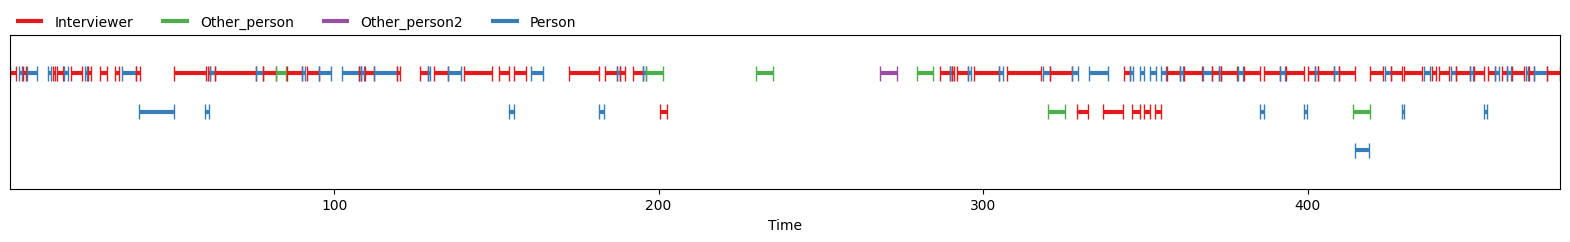

In [16]:
load_rttm("C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/1.rttm").popitem()[1]

In [18]:
Ref = load_rttm("C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/Reference/1.rttm").popitem()[1]
Hypo = load_rttm("C:/Users/sasha/OneDrive/Desktop/НИР/New Research/new_diar/default/1.rttm").popitem()[1]

In [19]:
jaccardErrorRate(Ref, Hypo, detailed=True)

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


{'speaker error': 1.7460624185959877,
 'speaker count': 4.0,
 'jaccard error rate': 0.4365156046489969}

In [22]:
newRef, newHypo = annotSet(Ref, Hypo)

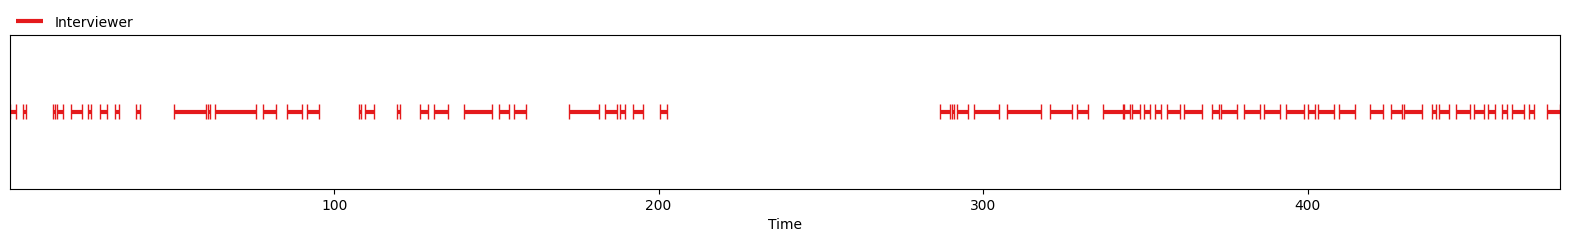

In [23]:
newRef

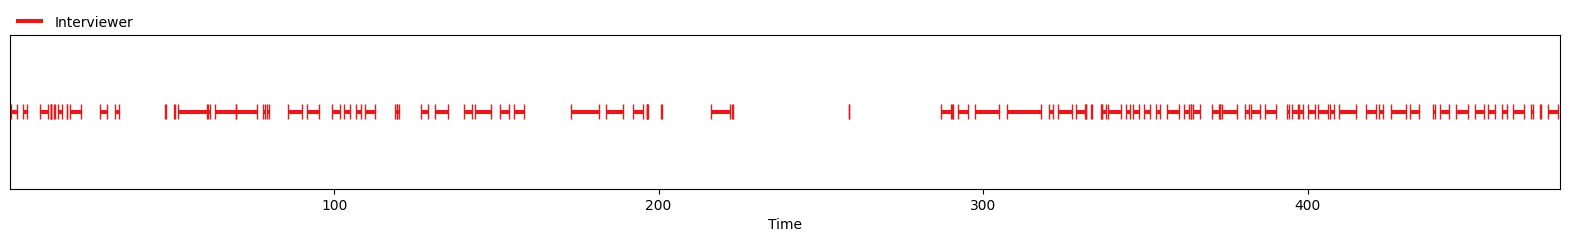

In [24]:
newHypo

In [25]:
jaccardErrorRate(newRef, newHypo, detailed=True)

{'speaker error': 0.23259057949229706,
 'speaker count': 1.0,
 'jaccard error rate': 0.23259057949229706}

In [ ]:
purity(ref.subset([speaker]),hypo.subset([speaker]), detailed=True)['total']
purity(ref.subset([speaker],invert=True),hypo.subset([speaker],invert=True), detailed=True)['total']
purity(ref.subset([speaker],invert=True),hypo.subset([speaker]), detailed=True)['total']
purity(ref.subset([speaker]),hypo.subset([speaker],invert=True), detailed=True)['total']

In [28]:
purity(newRef,newHypo, detailed=True)['total']

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


191.45100000000008

In [33]:
purity(newRef.subset(["Interviewer"]),newHypo.subset(["Interviewer"]), detailed=True)['total']

191.45100000000008

In [38]:
for segment, speaker, label in newRef.itertracks(yield_label=True):
    if label == "Interviewer":
        print(segment.start)

0.1
4.1
13.4
14.6
18.8
24.0
27.8
32.5
38.9
50.6
61.1
63.2
78.1
85.6
91.6
107.8
109.4
119.5
126.5
130.9
139.9
150.8
155.4
172.5
183.6
188.0
192.1
200.5
286.8
290.3
291.9
297.1
307.3
320.7
328.8
337.1
343.5
346.0
349.6
352.9
356.6
361.8
370.5
373.3
380.4
386.6
393.3
400.1
403.2
409.6
419.1
425.7
429.8
438.4
440.5
445.7
451.3
455.5
459.8
463.1
468.4
473.8


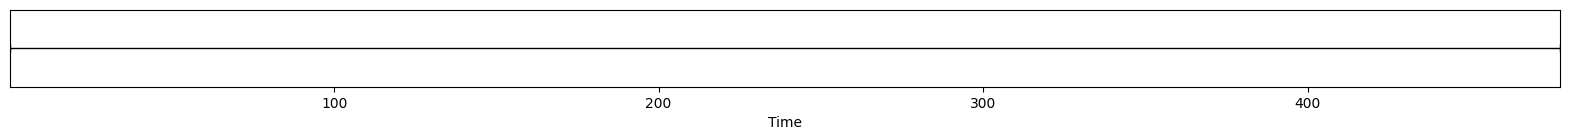

In [57]:
newAnn = Annotation()
newRef.get_timeline().extent()

In [46]:
audio = AudioSegment.from_file("C:/Users/sasha/OneDrive/Desktop/НИР/New Research/audio/default/1.wav")
eof = audio.duration_seconds

In [58]:
newAnn[Segment(0,eof)] = "Zero"

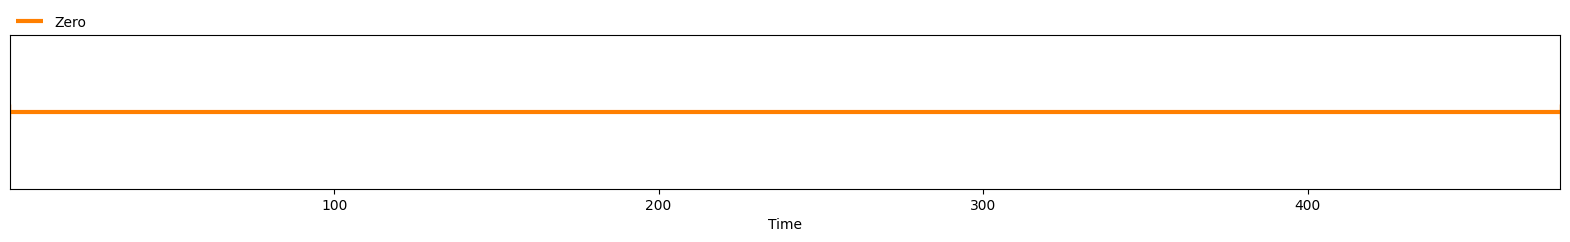

In [59]:
newAnn

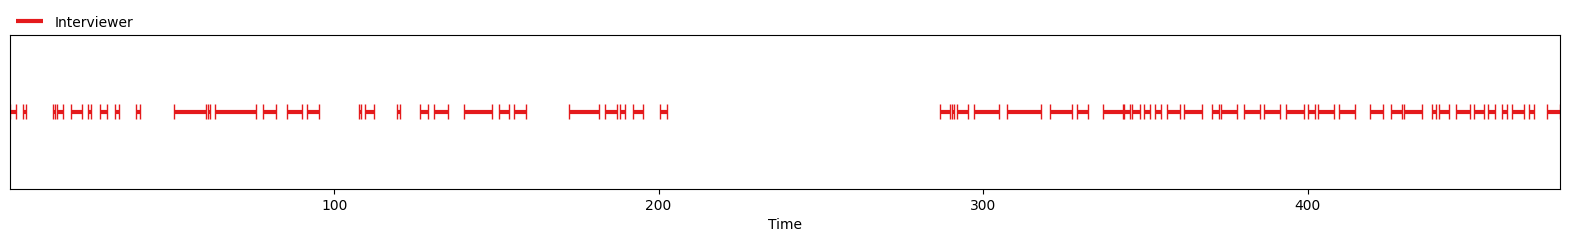

In [60]:
newRef

In [67]:
newAnn = newAnn.extrude(newRef.get_timeline())

In [69]:
newAnn[newRef.get_timeline()] = "Interviewer"

ValueError: too many values to unpack (expected 2)

In [15]:
methodName = "normalized"
main_path = "C:/Users/sasha/OneDrive/Desktop/НИР/New Research/"
folder_path = main_path + "diarization/"
RefRttm_path = "Reference/"
HypoRttm_path = methodName + "/"
research_path = main_path + "results/"

# Получаем список имен файлов в папке
RefFile_names = os.listdir(folder_path + RefRttm_path)
HypoFile_names = os.listdir(folder_path + HypoRttm_path)

# Сортируем имена файлов в алфавитном порядке
sorted_RefFiles = sorted(RefFile_names)
sorted_HypoFiles = sorted(HypoFile_names)

# Выводим отсортированные имена файлов
for files in sorted(sorted_RefFiles):
    print(files)
for files in sorted(sorted_HypoFiles):
    print(files)

abjxc.rttm
afjiv.rttm
akthc.rttm
ampme.rttm
atgpi.rttm
aufkn.rttm
azisu.rttm
bkwns.rttm
bwzyf.rttm
ccokr.rttm
cobal.rttm
cqaec.rttm
cwryz.rttm
cyyxp.rttm
djngn.rttm
dscgs.rttm
ehpau.rttm
eqttu.rttm
esrit.rttm
exymw.rttm
eziem.rttm
ezsgk.rttm
femmv.rttm
fsaal.rttm
fxgvy.rttm
ggvel.rttm
gpjne.rttm
gqbvk.rttm
gwtwd.rttm
gzvkx.rttm
hiyis.rttm
hqyok.rttm
ikgcq.rttm
imtug.rttm
iqtde.rttm
jhdav.rttm
jiqvr.rttm
jnivh.rttm
jsdmu.rttm
jsmbi.rttm
jyirt.rttm
kbkon.rttm
kctgl.rttm
kszpd.rttm
lknjp.rttm
luvfz.rttm
mesob.rttm
mevkw.rttm
migzj.rttm
mjgil.rttm
mpvoh.rttm
nctdh.rttm
ngyrk.rttm
nnqfq.rttm
nxgad.rttm
oekmc.rttm
oenox.rttm
plbbw.rttm
pqmho.rttm
qhesr.rttm
qjgpl.rttm
qppll.rttm
qpylu.rttm
qrzjk.rttm
qsfzo.rttm
qydmg.rttm
qzwxa.rttm
rcxzg.rttm
rtvuw.rttm
rxgun.rttm
sikkm.rttm
sldwj.rttm
spzmn.rttm
sqkup.rttm
syiwe.rttm
szsyz.rttm
tfvyr.rttm
tiams.rttm
tlprc.rttm
tucrg.rttm
uatlu.rttm
usbgm.rttm
uvnmy.rttm
vysqj.rttm
wdjyj.rttm
wewoz.rttm
whmpa.rttm
willh.rttm
wjhgf.rttm
wmori.rttm
xiglo.rttm

In [16]:
RefRttm = []
HypoRttm = []
i = 0
for files in sorted(sorted_RefFiles):
    RefRttm.append(load_rttm(folder_path + RefRttm_path + files).popitem()[1])
    i += 1
for files in sorted(sorted_HypoFiles):
    HypoRttm.append(load_rttm(folder_path + HypoRttm_path + files).popitem()[1])

In [17]:
Ref = []
Hypo = []
for j in range(i):
    RefTemp, HypoTemp = annotSet(RefRttm[j], HypoRttm[j])
    HypoTemp = renameAnnotes(RefTemp,HypoTemp)
    Ref.append(RefTemp)
    Hypo.append(HypoTemp)

In [26]:
#Подсчет метрик Accuracy, Precision, Recall, F1
def stats(ref, hypo, method, table):
    gTP = 0
    gTN = 0
    gFP = 0
    gFN = 0

    for speaker in ref.labels():
        truePositive = 0
        trueNegative = 0
        falsePositive = 0
        falseNegative = 0

        truePositive = purity(ref.subset([speaker]),hypo.subset([speaker]), detailed=True)['total']
        trueNegative = purity(ref.subset([speaker],invert=True),hypo.subset([speaker],invert=True), detailed=True)['total']
        falsePositive = purity(ref.subset([speaker],invert=True),hypo.subset([speaker]), detailed=True)['total']
        falseNegative = purity(ref.subset([speaker]),hypo.subset([speaker],invert=True), detailed=True)['total']
        
        gTP += truePositive
        gTN += trueNegative
        gFP += falsePositive
        gFN += falseNegative
        #print('truePositive: ' + str(truePositive))
        #print('trueNegative: ' + str(trueNegative))
        #print('falsePositive: ' + str(falsePositive))
        #print('falseNegative: ' + str(falseNegative))
        Accuracy = (truePositive+trueNegative)/(falsePositive+falseNegative+truePositive+trueNegative)

        temp = falsePositive+truePositive
        Precision = (truePositive)/temp if temp != 0 else 0

        temp = falseNegative+truePositive
        Recall = (truePositive)/temp if temp != 0 else 0
        #print(Recall)
        F1 = (2*Recall*Precision)/(Recall+Precision) if Recall+Precision != 0 else 0

        table.loc[len(table)] = [method, speaker, round(Accuracy,5), round(Precision,5), round(Recall,5), round(F1,5)]
    
    global ggTP, ggTN, ggFP, ggFN
    
    ggTP += gTP
    ggTN += gTN
    ggFP += gFP
    ggFN += gFN
    
    gAccuracy = (gTP+gTN)/(gFP+gFN+gTP+gTN)
    gPrecision = gTP/(gFP+gTP) if gFP+gTP != 0 else 0
    gRecall = gTP/(gFN+gTP) if gFN+gTP != 0 else 0
    gF1 = (2*gRecall*gPrecision)/(gRecall+gPrecision) if gRecall+gPrecision != 0 else 0
    table.loc[len(table)] = [method,"Общее",round(gAccuracy,5), round(gPrecision,5) ,round(gRecall,5), round(gF1,5) ]

#Выполнение подсчета метрик для всех данных
def st(Ref, Hypo, methodName, table):
    stats(Ref, Hypo, methodName, table)

In [27]:
ggTP = 0
ggTN = 0
ggFP = 0
ggFN = 0

if not os.path.exists(research_path + methodName + "/"):
    os.mkdir(research_path + methodName + "/")
    
writer = pd.ExcelWriter(research_path + methodName + '/ResultsF1.xlsx', engine='xlsxwriter')
table = pd.DataFrame(columns = ['Метод','Говорящий', 'Accuracy', 'Precision', 'Recall', 'F1'])
for j in range(i):
    st(Ref[j], Hypo[j], methodName, table)
table.set_index(['Метод','Говорящий']).to_excel(writer, sheet_name="Рез")
writer.close()

writer = pd.ExcelWriter(research_path + methodName + '/TotalF1.xlsx', engine='xlsxwriter')
total = pd.DataFrame(columns = ['Метод', 'Accuracy', 'Precision', 'Recall', 'F1'])

Accuracy = 0
Precision = 0
Recall = 0
F1 = 0

Accuracy = ((ggTP+ggTN)/(ggFP+ggFN+ggTP+ggTN))
Precision = (ggTP/(ggFP+ggTP))
Recall = (ggTP/(ggFN+ggTP))
F1 = ((2*Recall*Precision)/(Recall+Precision))

#Вывод средних метрик в зависимости от длительности
total.loc[len(total)] = [methodName, round(Accuracy,5), round(Precision,5) ,round(Recall,5), round(F1,5) ]
total.to_excel(writer, 'total')
writer.close()

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

In [28]:
def DERstats(ref, hypo, name, table):
    total = diarizationErrorRate(ref, hypo, detailed=True)['total']

    DER = round(diarizationErrorRate(ref, hypo, detailed=True)['diarization error rate']*100,2)
    Conf = round(diarizationErrorRate(ref, hypo, detailed=True)['confusion'] * 100 / total,2)
    Miss = round(diarizationErrorRate(ref, hypo, detailed=True)['missed detection'] * 100 / total,2)
    Alarm = round(diarizationErrorRate(ref, hypo, detailed=True)['false alarm'] * 100 / total,2)
    #print("Conf: " + str(Conf) + "\nDer: " + str(DER))
    global gConf, gMiss, gAlarm, gTime

    gConf += diarizationErrorRate(ref, hypo, detailed=True)['confusion']
    gMiss += diarizationErrorRate(ref, hypo, detailed=True)['missed detection']
    gAlarm += diarizationErrorRate(ref, hypo, detailed=True)['false alarm']
    gTime += diarizationErrorRate(ref, hypo, detailed=True)['total']
    #print("Conf: " + str(gConf[0]) + "\nTime: " + str(gTime[0]))
    
    table.loc[len(table)] = [ name, Alarm, Miss ,Conf, DER ]

def stDer(Ref, Hypo, methodName, table):
    DERstats(Ref, Hypo, methodName, table)

In [29]:
gConf = 0
gMiss = 0
gAlarm = 0
gTime = 0

writer = pd.ExcelWriter(research_path + methodName + '/DERResults.xlsx', engine='xlsxwriter')
table = pd.DataFrame(columns = ['Метод', 'Ложное срабатывание, %', 'Пропущенное обнаружение, %', 'Путаница, %', 'DER, %'])
for j in range (i):
    stDer(Ref[j], Hypo[j], methodName, table)
table.to_excel(writer, sheet_name="Рез")
writer.close()

writer = pd.ExcelWriter(research_path + methodName + '/DerTotal.xlsx', engine='xlsxwriter')
total = pd.DataFrame(columns = ['Метод', 'Ложное срабатывание, %', 'Пропущенное обнаружение, %', 'Путаница, %', 'DER, %'])

falseAlarmPer = 0
missPer = 0
confPer = 0
derPer = 0

falseAlarmPer = gAlarm*100/gTime
missPer = gMiss*100/gTime
confPer = gConf*100/gTime
derPer = (gAlarm + gMiss + gConf)*100/gTime
    
total.loc[len(total)] = [methodName, round(falseAlarmPer,2), round(missPer,2), round(confPer,2), round(derPer,2) ]

#total.loc[len(total)] = [round(gAlarm*100/gTime,5), round(gMiss*100/gTime,5) ,round(gConf*100/gTime,5), round((gAlarm + gMiss + gConf)*100/gTime,5) ] 
total.to_excel(writer, 'total')
writer.close()

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200:

In [38]:
def JERstats(ref, hypo, name, table):
    speakers = jaccardErrorRate(ref, hypo, detailed=True)['speaker count']
    JER = round(jaccardErrorRate(ref, hypo, detailed=True)['jaccard error rate']*100, 2)
    speakerError = round(jaccardErrorRate(ref, hypo, detailed=True)['speaker error'] * 100, 2)
    
    global gSpeakers, gSpeakerError

    gSpeakers += jaccardErrorRate(ref, hypo, detailed=True)['speaker count']
    gSpeakerError += jaccardErrorRate(ref, hypo, detailed=True)['speaker error']
    #print("Conf: " + str(gConf[0]) + "\nTime: " + str(gTime[0]))
    
    table.loc[len(table)] = [ name, speakers, speakerError ,JER ]

def stJer(Ref, Hypo, methodName, table):
    JERstats(Ref, Hypo, methodName, table)

In [39]:
gSpeakers = 0
gSpeakerError = 0

writer = pd.ExcelWriter(research_path + methodName + '/JERResults.xlsx', engine='xlsxwriter')
table = pd.DataFrame(columns = ['Метод', 'Количество акторов', 'Суммарная ошибка распознования акторов, %', 'JER, %'])
for j in range (i):
    stJer(Ref[j], Hypo[j], methodName, table)
table.to_excel(writer, sheet_name="Рез")
writer.close()

writer = pd.ExcelWriter(research_path + methodName + '/JerTotal.xlsx', engine='xlsxwriter')
total = pd.DataFrame(columns = ['Метод', 'Количество акторов', 'Суммарная ошибка распознования акторов, %', 'JER, %'])

jerPer = (gSpeakerError)*100/gSpeakers
    
total.loc[len(total)] = [methodName, gSpeakers, round(gSpeakerError,2), round(jerPer,2) ]

#total.loc[len(total)] = [round(gAlarm*100/gTime,5), round(gMiss*100/gTime,5) ,round(gConf*100/gTime,5), round((gAlarm + gMiss + gConf)*100/gTime,5) ] 
total.to_excel(writer, 'total')
writer.close()

C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\sasha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyannote\metrics\utils.py:200: